# Tutorial Basic

In [2]:
import pandas as pd
import numpy as np

from pyelegantsdds.elegantrun import ElegantRun
from pyelegantsdds.sdds import SDDS

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# path to singularity container with parallel elegant installed
sif = "/home/mti/gitlab-hzb/containers/bin/pelegant.sif"

## Setup example Elegant Lattice

In [101]:
# lattice element definitions
elements ={
    "QF": {"type" : "KQUAD", "L": 0.342, "K1":  0.4900, "N_KICKS": 16},
    "QD": {"type" : "KQUAD", "L": 0.668, "K1": -0.4999, "N_KICKS": 16},
    "D":  {"type" : "DRIF" , "L": 3.5805},
    "W1": {"type" : "WATCH", "filename":"\"%s-%03ld.w1\"","mode": "coordinates"}
}

FODOstr = "! FODO cell.\n\n"
stringlist = ["{:6}: {}".format(k,", ".join(["{}={:15.12f}".format(kk,vv) 
                                             if not isinstance(vv,str)
                                             else "{}={}".format(kk,vv)
                                             if kk!="type" else "{}".format(vv) for kk,vv in v.items()])) 
              for k,v in elements.items()]
line     = ["W1","QF","D","QD","D","QF"]
linestr  = "{:6}: LINE=({})".format("FODO",",".join(line))
FODOstr += "\n".join(stringlist)
FODOstr += "\n\n"
FODOstr += linestr

print(FODOstr)

with open("FODO.lte","w") as f:
    f.write(FODOstr)
    
# set lattice for the rest of the tutorial
lattice = "FODO.lte"

! FODO cell.

QF    : KQUAD, L= 0.342000000000, K1= 0.490000000000, N_KICKS=16.000000000000
QD    : KQUAD, L= 0.668000000000, K1=-0.499900000000, N_KICKS=16.000000000000
D     : DRIF, L= 3.580500000000
W1    : WATCH, filename="%s-%03ld.w1", mode=coordinates

FODO  : LINE=(W1,QF,D,QD,D,QF)


## ElegantRun class

The ElegantRun class is used to setup, control and run the Elegant simulations.

In [4]:
# load Elegant similator
er = ElegantRun(sif,lattice, parallel=True, use_beamline="FODO", energy=1700.00)

The *kwargs* argument is used to extract the settings for the simulations and building of the Elegant command file (temp.ele) - minimum required arguments are:
* use_beamline
* energy

Most command have default argument that can be changed by use of the *kwargs*, in this way simple simulations can be set up quickly and in just a few lines of python code. More complicated examples, using *kwargs* can be found in the **advanced tutorials**.

In [5]:
er.kwargs

{'use_beamline': 'FODO', 'energy': 1700.0}

The *parallel* argument allows to choose between running **serial** or **parallel** Elegant.

In [6]:
er.parallel

True

The latticefile used in the simulations is saved in the *lattice* property.

In [7]:
er.lattice

'FODO.lte'

## Internal elegant_command class

The ElegantRun class uses internally another class that takes care of organizing the Elegant control file. It allows to customize the control file for the simulations.

In [8]:
er.commandfile.commandlist, er.commandfile.history

([], {})

This class contains several commands to build a contral file.

In [9]:
# adds basic run_setup
er.add_basic_setup()

In [10]:
er.commandfile.commandlist, er.commandfile.history

([{'NAME': 'run_setup',
   'NOTE': '',
   'lattice': 'FODO.lte',
   'use_beamline': 'FODO',
   'p_central_mev': 1700.0,
   'centroid': '%s.cen',
   'default_order': 3,
   'concat_order': 3,
   'rootname': 'temp',
   'parameters': '%s.params',
   'semaphore_file': '%s.done',
   'magnets': '%s.mag'}],
 {})

In [11]:
# the write command writes the commandlist to an .ele file
er.commandfile.write(outputfilename='basic_test.ele')

In [12]:
with open('basic_test.ele','r') as f:
    cmd = f.read()
    
print(cmd)

&run_setup
	lattice             = FODO.lte,
	use_beamline        = FODO,
	p_central_mev       = 1700.0,
	centroid            = %s.cen,
	default_order       = 3,
	concat_order        = 3,
	rootname            = temp,
	parameters          = %s.params,
	semaphore_file      = %s.done,
	magnets             = %s.mag,
&end




In [13]:
# modify a command
# mode chooses the command (first, last or index[int])
er.commandfile.modifyCommand('run_setup', mode='last', default_order=2)

In [14]:
# notice the change of default_order
er.commandfile.commandlist ,er.commandfile.history

([{'NAME': 'run_setup',
   'NOTE': '',
   'lattice': 'FODO.lte',
   'use_beamline': 'FODO',
   'p_central_mev': 1700.0,
   'centroid': '%s.cen',
   'default_order': 2,
   'concat_order': 3,
   'rootname': 'temp',
   'parameters': '%s.params',
   'semaphore_file': '%s.done',
   'magnets': '%s.mag'}],
 {})

In [15]:
# clear the command list - updates history
er.commandfile.clear()

In [16]:
er.commandfile.commandlist ,er.commandfile.history

([],
 {0: [{'NAME': 'run_setup',
    'NOTE': '',
    'lattice': 'FODO.lte',
    'use_beamline': 'FODO',
    'p_central_mev': 1700.0,
    'centroid': '%s.cen',
    'default_order': 2,
    'concat_order': 3,
    'rootname': 'temp',
    'parameters': '%s.params',
    'semaphore_file': '%s.done',
    'magnets': '%s.mag'}]})

In [17]:
# one can also repeat a command
er.commandfile.addCommand('vary_element',name='*',item='K1', 
                          initial=1.0, final=1.5, index_number=0,index_limit=2)
er.commandfile.repeatCommand('vary_element',mode='last')

In [18]:
er.commandfile.commandlist ,er.commandfile.history

([{'NAME': 'vary_element',
   'NOTE': '',
   'name': '*',
   'item': 'K1',
   'initial': 1.0,
   'final': 1.5,
   'index_number': 0,
   'index_limit': 2},
  {'NAME': 'vary_element',
   'NOTE': '',
   'name': '*',
   'item': 'K1',
   'initial': 1.0,
   'final': 1.5,
   'index_number': 0,
   'index_limit': 2}],
 {0: [{'NAME': 'run_setup',
    'NOTE': '',
    'lattice': 'FODO.lte',
    'use_beamline': 'FODO',
    'p_central_mev': 1700.0,
    'centroid': '%s.cen',
    'default_order': 2,
    'concat_order': 3,
    'rootname': 'temp',
    'parameters': '%s.params',
    'semaphore_file': '%s.done',
    'magnets': '%s.mag'}]})

In [19]:
# clearing the commandfilelist and history
er.commandfile.clear()
er.commandfile.clearHistory()

In [20]:
er.commandfile.commandlist ,er.commandfile.history

([], {})

## Basic commands

In [23]:
# should always be used first
er.add_basic_setup()
er.commandfile.commandlist ,er.commandfile.history

([{'NAME': 'run_setup',
   'NOTE': '',
   'lattice': 'FODO.lte',
   'use_beamline': 'FODO',
   'p_central_mev': 1700.0,
   'centroid': '%s.cen',
   'default_order': 3,
   'concat_order': 3,
   'rootname': 'temp',
   'parameters': '%s.params',
   'semaphore_file': '%s.done',
   'magnets': '%s.mag'}],
 {})

In [24]:
er.add_basic_twiss()

In [25]:
er.commandfile.commandlist ,er.commandfile.history

([{'NAME': 'run_setup',
   'NOTE': '',
   'lattice': 'FODO.lte',
   'use_beamline': 'FODO',
   'p_central_mev': 1700.0,
   'centroid': '%s.cen',
   'default_order': 3,
   'concat_order': 3,
   'rootname': 'temp',
   'parameters': '%s.params',
   'semaphore_file': '%s.done',
   'magnets': '%s.mag'},
  {'NAME': 'twiss_output',
   'NOTE': '',
   'filename': '%s.twi',
   'matched': 1,
   'radiation_integrals': 1}],
 {})

In [26]:
er.add_vary_element()
er.commandfile.commandlist ,er.commandfile.history

([{'NAME': 'run_setup',
   'NOTE': '',
   'lattice': 'FODO.lte',
   'use_beamline': 'FODO',
   'p_central_mev': 1700.0,
   'centroid': '%s.cen',
   'default_order': 3,
   'concat_order': 3,
   'rootname': 'temp',
   'parameters': '%s.params',
   'semaphore_file': '%s.done',
   'magnets': '%s.mag'},
  {'NAME': 'twiss_output',
   'NOTE': '',
   'filename': '%s.twi',
   'matched': 1,
   'radiation_integrals': 1},
  {'NAME': 'vary_element',
   'NOTE': '',
   'name': '*',
   'item': 'L',
   'intial': 0.0,
   'final': 0.0,
   'index_number': 0,
   'index_limit': 1}],
 {})

In [27]:
er.add_watch_at_start()

In [28]:
er.commandfile.commandlist ,er.commandfile.history

([{'NAME': 'run_setup',
   'NOTE': '',
   'lattice': 'FODO.lte',
   'use_beamline': 'FODO',
   'p_central_mev': 1700.0,
   'centroid': '%s.cen',
   'default_order': 3,
   'concat_order': 3,
   'rootname': 'temp',
   'parameters': '%s.params',
   'semaphore_file': '%s.done',
   'magnets': '%s.mag'},
  {'NAME': 'twiss_output',
   'NOTE': '',
   'filename': '%s.twi',
   'matched': 1,
   'radiation_integrals': 1},
  {'NAME': 'vary_element',
   'NOTE': '',
   'name': '*',
   'item': 'L',
   'intial': 0.0,
   'final': 0.0,
   'index_number': 0,
   'index_limit': 1},
  {'NAME': 'insert_elements',
   'NOTE': '',
   'name': 'W',
   's_start': -1,
   's_end': -1,
   'skip': 1,
   'insert_before': 0,
   'add_at_end': 0,
   'add_at_start': 1,
   'element_def': '"W: WATCH, FILENAME=\\"%s-%03ld.wq\\", mode=\\"coordinates\\""'}],
 {})

In [29]:
er.add_basic_controls()
er.commandfile.commandlist ,er.commandfile.history

([{'NAME': 'run_setup',
   'NOTE': '',
   'lattice': 'FODO.lte',
   'use_beamline': 'FODO',
   'p_central_mev': 1700.0,
   'centroid': '%s.cen',
   'default_order': 3,
   'concat_order': 3,
   'rootname': 'temp',
   'parameters': '%s.params',
   'semaphore_file': '%s.done',
   'magnets': '%s.mag'},
  {'NAME': 'twiss_output',
   'NOTE': '',
   'filename': '%s.twi',
   'matched': 1,
   'radiation_integrals': 1},
  {'NAME': 'vary_element',
   'NOTE': '',
   'name': '*',
   'item': 'L',
   'intial': 0.0,
   'final': 0.0,
   'index_number': 0,
   'index_limit': 1},
  {'NAME': 'insert_elements',
   'NOTE': '',
   'name': 'W',
   's_start': -1,
   's_end': -1,
   'skip': 1,
   'insert_before': 0,
   'add_at_end': 0,
   'add_at_start': 1,
   'element_def': '"W: WATCH, FILENAME=\\"%s-%03ld.wq\\", mode=\\"coordinates\\""'},
  {'NAME': 'run_control', 'NOTE': ''},
  {'NAME': 'bunched_beam', 'NOTE': ''},
  {'NAME': 'track', 'NOTE': ''}],
 {})

In [30]:
# as example write to ele file and print 
er.commandfile.write('basic.ele')

with open('basic.ele', 'r') as f:
    cmd = f.read()
    
print(cmd)

&run_setup
	lattice             = FODO.lte,
	use_beamline        = FODO,
	p_central_mev       = 1700.0,
	centroid            = %s.cen,
	default_order       = 3,
	concat_order        = 3,
	rootname            = temp,
	parameters          = %s.params,
	semaphore_file      = %s.done,
	magnets             = %s.mag,
&end

&twiss_output
	filename            = %s.twi,
	matched             = 1,
	radiation_integrals = 1,
&end

&vary_element
	name                = *,
	item                = L,
	intial              = 0.0,
	final               = 0.0,
	index_number        = 0,
	index_limit         = 1,
&end

&insert_elements
	name                = W,
	s_start             = -1,
	s_end               = -1,
	skip                = 1,
	insert_before       = 0,
	add_at_end          = 0,
	add_at_start        = 1,
	element_def         = "W: WATCH, FILENAME=\"%s-%03ld.wq\", mode=\"coordinates\"",
&end

&run_control
&end

&bunched_beam
&end

&track
&end




In [33]:
er.clearAll()

In [34]:
er.add_watch(type='KQUAD',insert_before=1, 
             element_def = '"WQ: WATCH, FILENAME=\\"%s-%03ld.wq\\", mode=\\"coordinates\\""')
er.commandfile.commandlist

[{'NAME': 'insert_elements',
  'NOTE': '',
  'type': 'KQUAD',
  's_start': -1,
  's_end': -1,
  'skip': 1,
  'insert_before': 1,
  'add_at_end': 0,
  'add_at_start': 0,
  'element_def': '"WQ: WATCH, FILENAME=\\"%s-%03ld.wq\\", mode=\\"coordinates\\""'}]

In [35]:
er.clearAll()

Some variations of the basic commands exist and will be shown in more detail in the **advanced** tutorial.

In [36]:
er.add_vary_element_from_file()
er.commandfile.commandlist

External filename missing.


[]

In [38]:
er.add_vary_element_from_file(enumeration_file='scan.sdds')
er.commandfile.commandlist

[{'NAME': 'vary_element',
  'NOTE': '',
  'name': '*',
  'item': 'L',
  'index_number': 0,
  'index_limit': 1,
  'enumeration_file': 'scan.sdds',
  'enumeration_column': None}]

In [39]:
er.clearAll()

## Template Commands

### Twiss

In [47]:
# twiss
twidata, twipar = er.findtwiss()

# for example
print("Nux       : {:12.6f}".format(twipar.nux))
print("Nuy       : {:12.6f}".format(twipar.nuy))
print("dNux / dp : {:12.6f}".format(twipar['dnux/dp']))
print("dNuy / dp : {:12.6f}".format(twipar['dnuy/dp']))

Nux       :     0.235726
Nuy       :     0.234332
dNux / dp :    -0.289854
dNuy / dp :    -0.289250


In [7]:
# twiss data is returned as dataframe
twidata

,s,betax,alphax,psix,etax,etaxp,xAperture,betay,alphay,psiy,...,pCentral0,ElementName,ElementOccurence,ElementType,ChamberShape,dI1,dI2,dI3,dI4,dI5
0,0.0000,14.018177,0.000000e+00,0.000000,0.0,0.0,10.0,2.856023,9.761713e-17,0.000000,...,3326.816296,_BEG_,1,MARK,NaN,0.0,0.0,0.0,0.0,0.0
1,0.0000,14.018177,0.000000e+00,0.000000,0.0,0.0,10.0,2.856023,9.761713e-17,0.000000,...,3326.816296,W1,1,WATCH,?,0.0,0.0,0.0,0.0,0.0
2,0.3420,13.238180,2.236957e+00,0.024869,0.0,0.0,10.0,3.064602,-6.214851e-01,0.116974,...,3326.816296,QF,1,KQUAD,?,0.0,0.0,0.0,0.0,0.0
3,3.9225,3.033641,6.130754e-01,0.625301,0.0,0.0,10.0,13.314053,-2.241090e+00,0.712004,...,3326.816296,D,1,DRIF,?,0.0,0.0,0.0,0.0,0.0
4,4.5905,3.033641,-6.130754e-01,0.855812,0.0,0.0,10.0,13.314053,2.241090e+00,0.760351,...,3326.816296,QD,1,KQUAD,?,0.0,0.0,0.0,0.0,0.0
5,8.1710,13.238180,-2.236957e+00,1.456244,0.0,0.0,10.0,3.064602,6.214851e-01,1.355380,...,3326.816296,D,2,DRIF,?,0.0,0.0,0.0,0.0,0.0
6,8.5130,14.018177,1.665335e-16,1.481113,0.0,0.0,10.0,2.856023,2.498002e-16,1.472354,...,3326.816296,QF,2,KQUAD,?,0.0,0.0,0.0,0.0,0.0


In [14]:
# twiss header as series
pd.DataFrame(twipar)

,ParameterValue
ParameterName,
Step,0.000000
nux,0.235726
dnux/dp,-0.289854
dnux/dp2,0.000000
dnux/dp3,0.000000
...,...
Sdelta0,NaN
taudelta,NaN
Jdelta,NaN


### Find  matrices

In [5]:
er = ElegantRun(sif,lattice, parallel=True, use_beamline="FODO", energy=1700.00)
tup = er.find_matrices(SDDS_output_order=4)

In [6]:
tup[0]

array([[0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [8.513],
       [0.   ]])

In [7]:
tup[1]

array([[ 0.97148042,  0.33874254,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.16598385,  0.97148042,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  1.0287933 ,  0.34527618,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.16918533,  1.0287933 ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ]])

In [8]:
tup[2]

,s,ElementName,ElementOccurence,ElementType,C1,C2,C3,C4,C5,C6,...,U6652,U6653,U6654,U6655,U6661,U6662,U6663,U6664,U6665,U6666
0,0.0000,_BEG_,1,MARK,0.0,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0000,W1,1,WATCH,0.0,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.3420,QF,1,KQUAD,0.0,0.0,0.0,0.0,0.3420,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.9225,D,1,DRIF,0.0,0.0,0.0,0.0,3.5805,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.5905,QD,1,KQUAD,0.0,0.0,0.0,0.0,0.6680,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,8.1710,D,2,DRIF,0.0,0.0,0.0,0.0,3.5805,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,8.5130,QF,2,KQUAD,0.0,0.0,0.0,0.0,0.3420,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
tup[3]

{'T111': 0.0,
 'T121': 0.0,
 'T122': 0.0,
 'T131': 0.0,
 'T132': 0.0,
 'T133': 0.0,
 'T141': 0.0,
 'T142': 0.0,
 'T143': 0.0,
 'T144': 0.0,
 'T151': 0.0,
 'T152': 0.0,
 'T153': 0.0,
 'T154': 0.0,
 'T155': 0.0,
 'T161': 0.02838323777261919,
 'T162': 0.003248119974876812,
 'T163': 0.0,
 'T164': 0.0,
 'T165': 0.0,
 'T166': 0.0,
 'T211': 0.0,
 'T221': 0.0,
 'T222': 0.0,
 'T231': 0.0,
 'T232': 0.0,
 'T233': 0.0,
 'T241': 0.0,
 'T242': 0.0,
 'T243': 0.0,
 'T244': 0.0,
 'T251': 0.0,
 'T252': 0.0,
 'T253': 0.0,
 'T254': 0.0,
 'T255': 0.0,
 'T261': 0.1643922678358144,
 'T262': 0.02838323777261919,
 'T263': 0.0,
 'T264': 0.0,
 'T265': 0.0,
 'T266': 0.0,
 'T311': 0.0,
 'T321': 0.0,
 'T322': 0.0,
 'T331': 0.0,
 'T332': 0.0,
 'T333': 0.0,
 'T341': 0.0,
 'T342': 0.0,
 'T343': 0.0,
 'T344': 0.0,
 'T351': 0.0,
 'T352': 0.0,
 'T353': 0.0,
 'T354': 0.0,
 'T355': 0.0,
 'T361': 0.0,
 'T362': 0.0,
 'T363': -0.02893069101481531,
 'T364': -0.003285565711564714,
 'T365': 0.0,
 'T366': 0.0,
 'T411': 0.0,
 'T42

In [10]:
tup[4]

{'Q1111': -0.0001970002948894715,
 'Q1211': 0.004652730258634746,
 'Q1221': -0.04136873240450344,
 'Q1222': -0.004789182612360013,
 'Q1311': 0.0,
 'Q1321': 0.0,
 'Q1322': 0.0,
 'Q1331': -0.0002020832426886925,
 'Q1332': 0.001586809662604549,
 'Q1333': 0.0,
 'Q1411': 0.0,
 'Q1421': 0.0,
 'Q1422': 0.0,
 'Q1431': -0.00324741357041098,
 'Q1432': 0.02865118002690505,
 'Q1433': 0.0,
 'Q1441': -0.01460403366730693,
 'Q1442': 0.001614327079101474,
 'Q1443': 0.0,
 'Q1444': 0.0,
 'Q1511': 0.0,
 'Q1521': 0.0,
 'Q1522': 0.0,
 'Q1531': 0.0,
 'Q1532': 0.0,
 'Q1533': 0.0,
 'Q1541': 0.0,
 'Q1542': 0.0,
 'Q1543': 0.0,
 'Q1544': 0.0,
 'Q1551': 0.0,
 'Q1552': 0.0,
 'Q1553': 0.0,
 'Q1554': 0.0,
 'Q1555': 0.0,
 'Q1611': 0.0,
 'Q1621': 0.0,
 'Q1622': 0.0,
 'Q1631': 0.0,
 'Q1632': 0.0,
 'Q1633': 0.0,
 'Q1641': 0.0,
 'Q1642': 0.0,
 'Q1643': 0.0,
 'Q1644': 0.0,
 'Q1651': 0.0,
 'Q1652': 0.0,
 'Q1653': 0.0,
 'Q1654': 0.0,
 'Q1655': 0.0,
 'Q1661': -0.0282811777828586,
 'Q1662': -0.003241127611177823,
 'Q1663': 0.

### Tracking

#### Sinlge particle simple

In [102]:
er = ElegantRun(sif,lattice, parallel=True, use_beamline="FODO", energy=1700.00)
er.simple_single_particle_track(n_passes=100, coord=np.array([1e-5,0,0,0,0]))

Shape: (1, 6) - Number of paritcles: 1 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount


In [103]:
# quick plot
sddsp = SDDS(sif,"temp-001.w1",0)

sddsp.sddsplot_base(
    columnNames="x,xp",
#     file="temp-001.w1",
    graph="symb,vary=subtype,fill",
    device='png',
    output="FODO_single_particle.png"
)

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp-001.w1 -columnNames=x,xp -graph=symb,vary=subtype,fill -device=png -output=FODO_single_particle.png


![title](FODO_single_particle.png)

In [27]:
er.kwargs.get('energy')

1700.0

In [19]:
# generate rectangular coordinate input file - auto
# if pcentralmev is not given the energy value in er.kwargs will be used
er.generate_sdds_particle_inputfile(grid_type='rectangular', p_min=1e-6, p_max=1e-2, 
                                    pcentralmev=er.kwargs.get('energy'),
                                    NPOINTS=7
                                   )

Shape: (16807, 6) - Number of paritcles: 16807 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount


In [11]:
sddsp = SDDS(sif,"temp_particles_input.bin",0)
df = sddsp.readParticleData()

Warning - auto filename set
Changed from temp_particles_input.bin to temp_particles_input.bin.txt
Warning - auto filetype set
Changed from 0 to 1


<IPython.core.display.Javascript object>


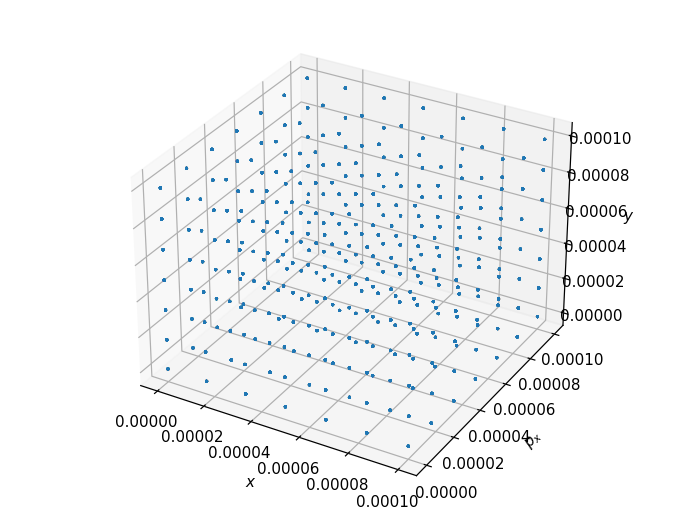

In [13]:
from matplotlib import pyplot as plt
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.x,df.xp,df.y,s=1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p_x$')
ax.set_zlabel(r'$y$')
plt.tight_layout()
plt.show()

In [5]:
# track
er.track_simple(n_passes=2**6)

NameError: name 'er' is not defined

In [6]:
# quick plot
sddsp = SDDS(sif,"temp-001.w1",0)

sddsp.sddsplot_base(
    columnNames="x,xp",
    file="temp-001.w1",
#     scale="-1e-4,1e-4,0,0",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
    device='png',
    output="FODO_multi_particle_rectangular2.png"
)

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -columnNames=x,xp temp-001.w1 -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID -device=png -output=FODO_multi_particle_rectangular2.png


![title](FODO_multi_particle_rectangular2.png)

In [9]:
# generate rectangular coordinate input file - auto
# if pcentralmev is not given the energy value in er.kwargs will be used
er = ElegantRun(sif,lattice, parallel=True, use_beamline="FODO", energy=1700.00)
er.generate_sdds_particle_inputfile(grid_type='spherical',  
                                    dim=6,
                                    rmin=1e-6,
                                    rmax=1e-4,
                                    rsteps=5,
                                    phisteps=10,
                                    half=True, # False gives full spheres
                                    pcentralmev=er.kwargs.get('energy'),
                                   )

Shape: (5000, 6) - Number of paritcles: 5000 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount


In [5]:
sddsp = SDDS(sif,"temp_particles_input.bin",0)
df = sddsp.readParticleData()

Warning - auto filename set
Changed from temp_particles_input.bin to temp_particles_input.bin.txt
Warning - auto filetype set
Changed from 0 to 1


<IPython.core.display.Javascript object>


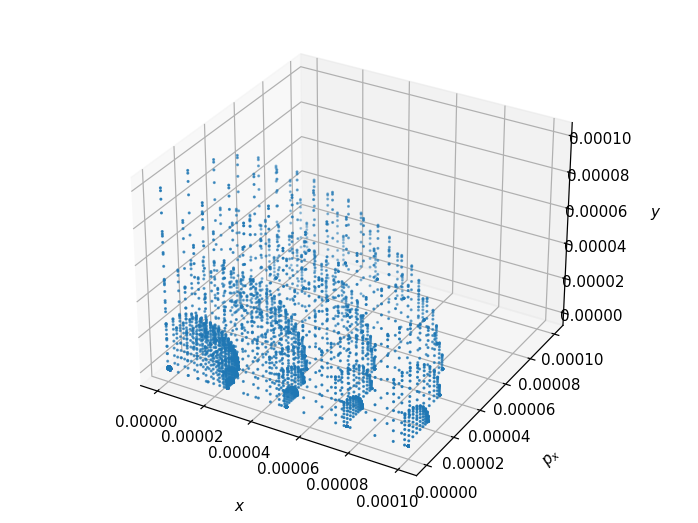

In [10]:
from matplotlib import pyplot as plt
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.xaxis.labelpad=15
ax.yaxis.labelpad=15
ax.zaxis.labelpad=15

ax.scatter(df.x,df.xp,df.y,s=1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p_x$')
ax.set_zlabel(r'$y$')
plt.tight_layout()
plt.show()

In [17]:
# track
er.track_simple(n_passes=2)

In [13]:
sddsp = SDDS(sif,"temp-001.w1",0)
df = sddsp.readParticleData()

Warning - auto filename set
Changed from temp-001.w1 to temp-001.w1.txt
Warning - auto filetype set
Changed from 0 to 1


<IPython.core.display.Javascript object>


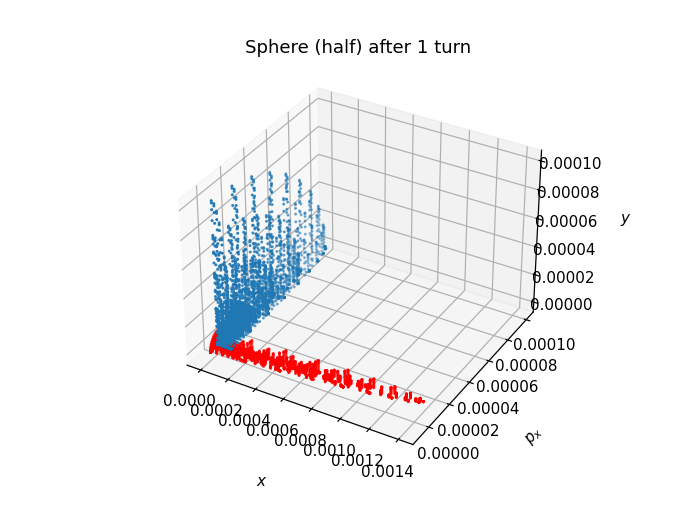

In [15]:
from matplotlib import pyplot as plt
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.loc[df.Turn==1].x,df.loc[df.Turn==1].xp,df.loc[df.Turn==1].y,s=1)
ax.scatter(df.loc[df.Turn==2].x,df.loc[df.Turn==2].xp,df.loc[df.Turn==2].y,s=1,c='red')

ax.xaxis.labelpad=15
ax.yaxis.labelpad=15
ax.zaxis.labelpad=15

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p_x$')
ax.set_zlabel(r'$y$')

plt.title('Sphere (half) after 1 turn')
plt.show()

# Advanced

In [116]:
# Lattice parTrack from Elegant examples
latstr = """
l1a: DRIF, L=0.2
l1b: DRIF, L=1.531675
lqb: DRIF, L=0.24
l2:  DRIF, L=0.08
l3:  DRIF, L=1.47
l3a: DRIF, L=0.568095770758662
l3b: DRIF, L=0.551904229241338

! LHK is half the effective length of a kicker
lhk:  DRIF, L=0.175
l34a: DRIF, L=0.811087
l34b: DRIF, L=0.308913

l4: DRIF, L=0.08
l5: DRIF, L=0.325

b1: CSBEND, L=0.8, angle=-0.785398163397, e1=-0.445, e2=-0.445, k2=0.1375, k3=100, hgap=0.0225, fint=0.41, integration_order=4, n_kicks=20, nonlinear=1
b2: CSBEND, L=0.8, angle=-0.785398163397, e1=-0.445, e2=-0.445, k2=0.1375, k3=100, hgap=0.0225, fint=0.41, integration_order=4, n_kicks=20, nonlinear=1

q1: KQUAD, L=0.23, k1=1.786022448154, n_kicks=10
q2: KQUAD, L=0.23, k1=2.295915530046, n_kicks=10
q3: KQUAD, l=0.23, k1=0.0
q4: KQUAD, l=0.23, k1=2.270174600496, n_kicks=10

s1h: SEXT, l=0.1, k2=0.0

! vertical chromaticity sextupole plus vertical steering magnet
sdh: KSEXT, l=0.1, k2=5.95873739969822, n_kicks=4

! horizontal chromaticity sextupole plus horizontal steering magnet
sfh: ksextupole, l=0.1, k2=-1.65546424863732, n_kicks=4

s1: line=(s1h,s1h)
sd: line=(sdh,sdh)
sf: line=(sfh,sfh)

! markers for the septum center and the center of the RF straight
msept: marker
mrf:   marker

! quadrant 1, less half of SF
quadr1: line=(l1a,l1b,s1,l2,q1,lqb,b1,lqb,q2,l3a,lhk,lhk,l3b,sd,l4,q3,lqb,b2,lqb,q4,l5)

! quadrant 2, less half of SF
quadr2: line=(l1a,l1b,s1,l2,q1,lqb,b1,lqb,q2,l3a,lhk,lhk,l3b,sd,l4,q3,lqb,b2,lqb,q4,l5)

! quadrant 3, less half of SF
quadr3: line=(l1a,l1b,s1,l2,q1,lqb,b1,lqb,q2,l3,sd,l4,q3,lqb,b2,lqb,q4,l5)

! quadrant 4, less half of SF
quadr4: line=(l1a,l1b,s1,l2,q1,lqb,b1,lqb,q2,l34a,lhk,lhk,l34b,sd,l4,q3,lqb,b2,lqb,q4,l5)

half: line=(quadr2,sf,-quadr2)

ap: rcol,x_max=0.04,y_max=0.01
par: line=(2*half,ap)
return

""".upper()

with open('parTrack.lte','w') as f:
    f.write(latstr)

In [10]:
lattice = 'parTrack.lte'

In [164]:
er = ElegantRun(sif,lattice, parallel=True, use_beamline="par", energy=880.00)
er.fma(xmin=-0.05,xmax=0.05,ymin=0,ymax=0.02,nx=51,ny=51, n_passes=256)

In [136]:
sddsp = SDDS(sif,'temp.fma',0)

In [163]:
sddsp.sddsplot_fma(
    file="temp.fma",
    device='png',
    output="partrack_fma_diffusionrate.png"
)

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp.fma -col=x,y -graph=sym,vary=subtype,fill,scale=2,fill -order=spectral -split=column=diffusionRate -device=png -output=partrack_fma_diffusionrate.png


![title](partrack_fma_diffusionrate.png)

In [162]:
sddsp.sddsplot_tunediagram(scale="0,1,0,1", device='png',output="partrack_tune.png" )

Executing : 
/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsresdiag resdiag.sdds
Executing : 
/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -columnNames=nux,nuy temp.fma -scale=0,1,0,1 -graph=sym,fill,vary=subtype -order=spect -split=col=x -col=nux,nuy resdiag.sdds -sever -device=png -output=partrack_tune.png


![title](partrack_tune.png)

In [14]:
er = ElegantRun(sif,lattice, parallel=True, use_beamline="par", energy=880)
# parallel only supports n-line
er.dynap(xmin=-0.1,xmax=0.1,ymin=0,ymax=0.1,nx=21,ny=21,n_lines=51)

In [48]:
sddsp = SDDS(sif,"temp.aper",0)
sddsp.process_scan()

Executing : 
/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsprocess -define=column,step,Step temp.aper temp_processed.aper
Warning - auto filename set
Changed from temp.aper to temp_processed.aper


In [49]:
sddsp.readParticleData()

Warning - auto filename set
Changed from temp_processed.aper to temp_processed.aper.txt
Warning - auto filetype set
Changed from 0 to 1


KeyError: 'particleID'

In [16]:
sddsp.sddsplot_base(col="x,y",file1=sddsp.filename, device='png',output="partrack_aper.png")

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -col=x,y temp.aper -device=png -output=partrack_aper.png


![title](partrack_aper.png)

In [182]:
sddsp.addCommand('sddsplot', col='x,y', file=sddsp.filename,
                 graph="sym,vary=subtype",
                 order='spectral',split='column=sLost',
                )

In [ ]:
er.commandfile.addCommand('run_setup',lattice='parTrack.lte')

In [86]:
sddsp.getColumnList()

['x', 'y', 'xClipped', 'yClipped', 'sLost', 'xLost', 'yLost']

In [99]:
sddsp.getParameterList()

['Step', 'SVNVersion', 'Area']

In [183]:
sddsp.runCommand()

Executing : 
/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -col=x,y temp.aper -graph=sym,vary=subtype -order=spectral -split=column=sLost


In [91]:
sddsp.command_history

{0: ['/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -col=x,y temp.aper'],
 1: ['/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsquery -columnList temp.aper'],
 2: ['/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -col=x,y -split=sLost temp.aper'],
 3: ['/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -col=x,y -split=sLost temp.aper'],
 4: ['/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -col=x,y temp.aper -graph=sym,vary=subtype,fill,scale=2 -order=spectral -split=sLost'],
 5: ['/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -col=x,y temp.aper -graph=sym,vary=subtype,fill,scale=2 -order=spectral -split=sLost'],
 6: ['/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsquery -columnList temp.aper'],
 7: ['/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -col=x,y temp.aper'],
 8: ['/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -col=x,y temp.aper'],
 9: ['/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsp

In [94]:
 datasetdc = {
        "Q1" : [1.786022448154-0.01,1.786022448154+0.01],
        "Q2" : [2.295915530046-0.01,2.295915530046+0.01],
     
 }

er = ElegantRun(sif,lattice, parallel=True, use_beamline="par", energy=880.00)
er.generate_sdds_particle_inputfile(grid_type='rectangular', p_min=1e-6, p_max=1e-2, 
                                    pcentralmev=er.kwargs.get('energy'),
                                    NPOINTS=3
                                   )
er.track_vary(varydict=datasetdc,varyitemlist=['k1',"k1"],n_passes=2**4, add_watch_start=True, mode='row')

Shape: (243, 6) - Number of paritcles: 243 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount


In [95]:
sdds = SDDS(sif, "temp-001.wq",0)
sdds.process_scan()

Executing : 
/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsprocess -define=column,step,Step temp-001.wq temp-001_processed.wq
Warning - auto filename set
Changed from temp-001.wq to temp-001_processed.wq


In [96]:
data = sdds.readParticleData()
data


Warning - auto filename set
Changed from temp-001_processed.wq to temp-001_processed.wq.txt
Warning - auto filetype set
Changed from 0 to 1


,x,xp,y,yp,t,p,dt,particleID,step,Turn
0,0.000000,0.000000,0.000000,0.000000,0.000000,1722.116751,0.000000e+00,1,1.0,1
1,0.000000,0.000000,0.000000,0.000000,0.000050,1722.116751,5.000000e-05,2,1.0,1
2,0.000000,0.000000,0.000000,0.000000,0.000100,1722.116751,1.000000e-04,3,1.0,1
3,0.000000,0.000000,0.000000,0.000050,0.000000,1722.116751,0.000000e+00,4,1.0,1
4,0.000000,0.000000,0.000000,0.000050,0.000050,1722.116751,5.000000e-05,5,1.0,1
...,...,...,...,...,...,...,...,...,...,...
7771,-0.000213,-0.000033,0.000214,0.000047,0.000052,1722.116751,5.000000e-05,239,2.0,32
7772,-0.000213,-0.000033,0.000214,0.000047,0.000102,1722.116751,1.000000e-04,240,2.0,32
7773,-0.000214,-0.000033,0.000335,0.000095,0.000002,1722.116751,8.013319e-14,241,2.0,32
7774,-0.000214,-0.000033,0.000335,0.000095,0.000052,1722.116751,5.000000e-05,242,2.0,32


In [66]:
sdds = SDDS(sif, "temp.sdds",0)

In [67]:
sdds.getColumnValues()

,Q1,Q2
0,1.776022,2.285916
1,1.796022,2.305916


In [79]:
# quick plot
sddsp = SDDS(sif,"temp-001.wq",0)

sddsp.sddsplot_base(
    columnNames="x,xp",
    file="temp-001.w1",
#     scale="-1e-4,1e-4,0,0",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
#     device='png',
#     output="FODO_multi_particle_rectangular2.png"
)

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -columnNames=x,xp temp-001.w1 -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID


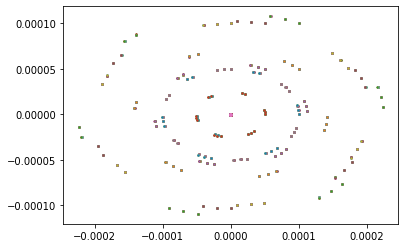

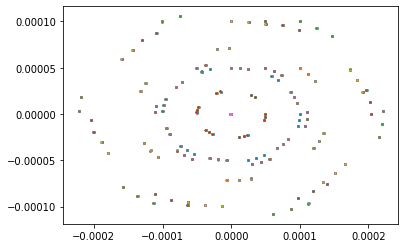

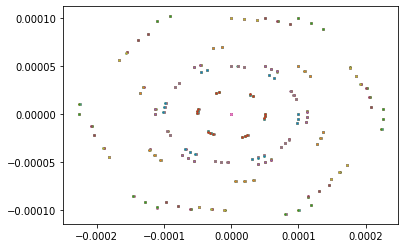

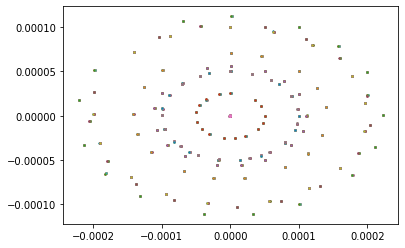

In [90]:
import matplotlib.pyplot as plt

for i in [1.0*n for n in range(1,23)]:
    for name, group in data.loc[data.step==i].groupby("particleID"):
        plt.scatter(group["x"],group["xp"],s=1, label=name)
    #plt.xlim(-1,1)
    plt.show()